# Setup

In [1]:
cd ..

d:\Google Drive\Github\lc-classification


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from src.config import *

# Prepare data

In [3]:
# import dataset
metadata = pd.read_json('./data/interim/metadata.json')
train_set = pd.read_json(TRAIN_DIR)
val_set = pd.read_json(VAL_DIR)
test_set = pd.read_json(TEST_DIR)

# import embeddings vectors
train_embeddings = pd.read_json('./work/longformer_train_embeddings.json').reset_index(drop=True)
val_embeddings = pd.read_json('./work/longformer_val_embeddings.json').reset_index(drop=True)
test_embeddings = pd.read_json('./work/longformer_test_embeddings.json').reset_index(drop=True)

# join datasets
train_fullset = train_embeddings.merge(train_set, left_on='id', right_on='id')
val_fullset = val_embeddings.merge(val_set, left_on='id', right_on='id')
test_fullset = test_embeddings.merge(test_set, left_on='id', right_on='id')

In [4]:
# create labels for classes
labels = sorted(list(set(train_fullset.y_class)))
class2label = {}
for i in range(len(labels)):
    class2label[labels[i]] = i
label2class = {v:k for k,v in class2label.items()}
train_fullset['y_class_labels'] = train_fullset['y_class'].apply(lambda x: class2label[x])
val_fullset['y_class_labels'] = val_fullset['y_class'].apply(lambda x: class2label[x])
test_fullset['y_class_labels'] = test_fullset['y_class'].apply(lambda x: class2label[x])

# Train classifiers

## Random Forest

In [5]:
# train random forest model
start = time.time()
rf = RandomForestClassifier(n_estimators=512, max_depth=12, random_state=0)    # max_depth tuned range(3,16)
rf.fit(np.array(list(train_fullset.embeddings)), train_fullset.y_class_labels)
y_hat = rf.predict(np.array(list(val_fullset.embeddings)))
end = time.time()
print("Runtime:", round((end-start)//60), "min",  round((end-start)%60), "sec")

Runtime: 11 min 11 sec


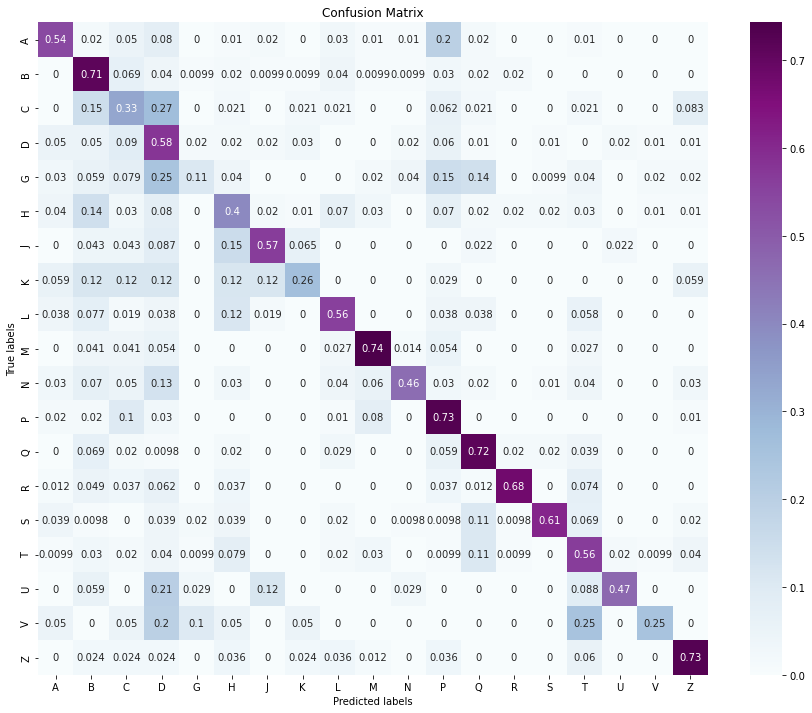

In [6]:
cm = confusion_matrix(y_true=val_fullset.y_class_labels, y_pred=y_hat, labels=list(class2label.values()), normalize='true')
cm_df = pd.DataFrame(cm, index=[i for i in labels], columns=[i for i in labels])
plt.figure(figsize = (15,12))
ax = plt.subplot()
sn.heatmap(cm_df, annot=True, cmap='BuPu', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

## SVM

In [7]:
# train svm model
start = time.time()
svm = SVC(C=500, random_state=0)    # C tuned [1, 10, 100, 500, 1000]
svm.fit(np.array(list(train_fullset.embeddings)), train_fullset.y_class_labels)
y_hat = svm.predict(np.array(list(val_fullset.embeddings)))
print(i, round(accuracy_score(val_fullset.y_class_labels, y_hat), 4))
end = time.time()
print("Runtime:", round((end-start)//60), "min",  round((end-start)%60), "sec")

18 0.652
Runtime: 9 min 36 sec


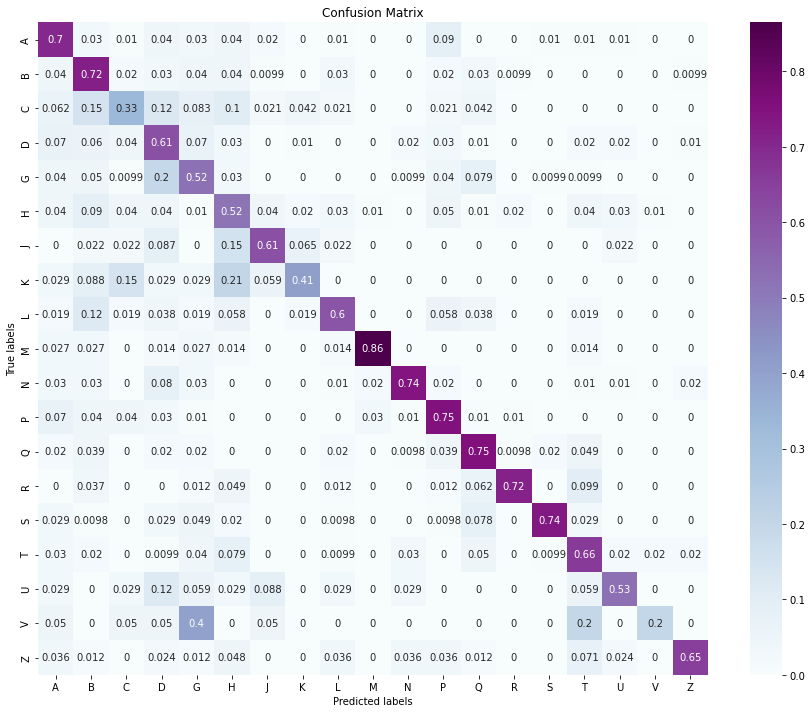

In [8]:
cm = confusion_matrix(y_true=val_fullset.y_class_labels, y_pred=y_hat, labels=list(class2label.values()), normalize='true')
cm_df = pd.DataFrame(cm, index=[i for i in labels], columns=[i for i in labels])
plt.figure(figsize = (15,12))
ax = plt.subplot()
sn.heatmap(cm_df, annot=True, cmap='BuPu', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()